# Imports

In [1]:
import os
import copy

import cv2
import numpy as np

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import xml.etree.ElementTree as ET

%matplotlib inline
np.set_printoptions(suppress=True)

# XML File Parser

In [2]:
def parse_annotation(ann_dir, img_dir, labels=[]):
    all_imgs = []
    seen_labels = {}

    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue
        img = {'object':[]}

        tree = ET.parse(ann_dir + ann)

        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist!\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels) > 0 and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]
                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']]  = 1

                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_imgs += [img]

    return all_imgs, seen_labels

# Using `ANCHORS` obtained by [Yumi](https://fairyonice.github.io/)

In [3]:
train_image_folder = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/"
train_annot_folder = "/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/Annotations/"

ANCHORS = np.array([1.07709888,  1.78171903,  # anchor box 1, width , height
                    2.71054693,  5.12469308,  # anchor box 2, width,  height
                   10.47181473, 10.09646365,  # anchor box 3, width,  height
                    5.48531347,  8.11011331]) # anchor box 4, width,  height

LABELS = ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
          'bus',        'car',      'cat',  'chair',     'cow',
          'diningtable','dog',    'horse',  'motorbike', 'person',
          'pottedplant','sheep',  'sofa',   'train',   'tvmonitor']

train_image, seen_train_labels = parse_annotation(train_annot_folder,train_image_folder, labels=LABELS)
print("N train = {}".format(len(train_image)))

N train = 17125


# Sample File

In [4]:
train_image[0]

{'object': [{'name': 'person',
   'xmin': 174,
   'ymin': 101,
   'xmax': 349,
   'ymax': 351}],
 'filename': '/kaggle/input/pascal-voc-2012-dataset/VOC2012_train_val/VOC2012_train_val/JPEGImages/2007_000027.jpg',
 'width': 486,
 'height': 500}

# Class Distribution

In [5]:
seen_train_labels

{'person': 17401,
 'aeroplane': 1002,
 'tvmonitor': 893,
 'train': 704,
 'boat': 1059,
 'dog': 1598,
 'chair': 3056,
 'bird': 1271,
 'bicycle': 837,
 'bottle': 1561,
 'sheep': 1084,
 'diningtable': 800,
 'horse': 803,
 'motorbike': 801,
 'sofa': 841,
 'cow': 771,
 'car': 2492,
 'cat': 1277,
 'bus': 685,
 'pottedplant': 1202}

# `ImageReader` class to process images
### Takes in an image and returns the resized `image` and all the `objects` in the image

In [6]:
class ImageReader(object):

    def __init__(self, IMAGE_H, IMAGE_W, norm=None):
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm    = norm

    def encode_image(self, image, reorder_rgb=True):
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))

        if reorder_rgb:
            image = image[:,:,::-1]
        if self.norm is not None:
            image = self.norm(image)

        return(image)

    def fit(self, train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.

        -- Input --

        train_instance : dictionary containing filename, height, width and object

        {'filename': 'ObjectDetectionRCNN/VOCdevkit/VOC2012/JPEGImages/2008_000054.jpg',
         'height':   333,
         'width':    500,
         'object': [{'name': 'bird',
                     'xmax': 318,
                     'xmin': 284,
                     'ymax': 184,
                     'ymin': 100},
                    {'name': 'bird',
                     'xmax': 198,
                     'xmin': 112,
                     'ymax': 209,
                     'ymin': 146}]
        }

        '''
        if not isinstance(train_instance,dict):
            train_instance = {'filename':train_instance}

        image_path = train_instance['filename']
        image = cv2.imread(image_path)
        h, w, c = image.shape
        
        if image is None: print('Cannot find ', image_path)

        image = self.encode_image(image, reorder_rgb=True)

        if "object" in train_instance.keys():

            all_objs = copy.deepcopy(train_instance['object'])

            # fix object's position and size
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

# Sample usage of `ImageReader`

Old bounding box coordinates: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
New bounding box coordinates: [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


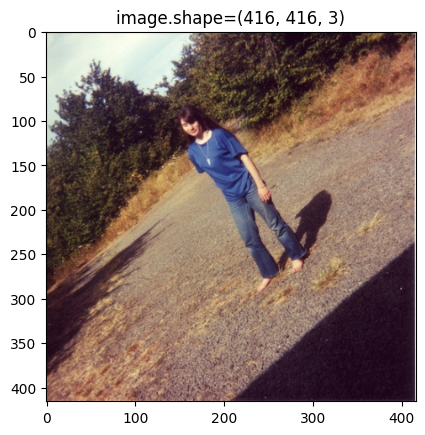

In [7]:
def normalize(image):
    return image / 255.

train_image_single = train_image[0]
print("Old bounding box coordinates: {}".format(train_image_single['object']))

inputEncoder = ImageReader(IMAGE_H=416,IMAGE_W=416, norm=normalize)
image, all_objs = inputEncoder.fit(train_image_single)

print("New bounding box coordinates: {}".format(all_objs))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.show()

# `BestAnchorBoxFinder` class to finds best anchor box for each object

In [8]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of even number length e.g.

        _ANCHORS = [4,2, ##  width=4, height=2,  flat large anchor box
                    2,4, ##  width=2, height=4,  tall large anchor box
                    1,1] ##  width=1, height=1,  small anchor box
        '''
        
        self.anchors = []
        for i in range(int(len(ANCHORS)//2)):
            self.anchors.append(BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]))

        # self.anchors = [
        # BoundBox(xmin=0, ymin=0, xmax=0.08285376, ymax=0.13705531, confidence=None, classes=None)
        # BoundBox(xmin=0, ymin=0, xmax=0.20850361, ymax=0.39420716, confidence=None, classes=None)
        # BoundBox(xmin=0, ymin=0, xmax=0.80552421, ymax=0.77665105, confidence=None, classes=None)
        # BoundBox(xmin=0, ymin=0, xmax=0.42194719, ymax=0.62385487, confidence=None, classes=None)    
        # ]


    def _interval_overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3

    def find_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union

    def find(self, width, height):        
        input_box = BoundBox(0, 0, width, height)

        iou_list = []
        for i in range(len(self.anchors)):
            iou_list.append(self.find_iou(input_box, self.anchors[i]))

        return max(enumerate(iou_list), key=lambda x: x[1])


class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None, classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax

        self.confidence = confidence
        self.set_class(classes)

    def set_class(self, classes):
        self.classes = classes
        self.label   = np.argmax(self.classes)

    def get_label(self):
        return(self.label)

    def get_score(self):
        return(self.classes[self.label])
    
    
    def __repr__(self):
        return("BoundBox(xmin={}, ymin={}, xmax={}, ymax={}, confidence={}, classes={})".format(
            self.xmin, self.ymin, self.xmax, self.ymax, self.confidence, self.classes))

# Sample usage of `BestAnchorBoxFinder`

In [9]:
# Anchor box width and height found in https://fairyonice.github.io/Part_1_Object_Detection_with_Yolo_for_VOC_2014_data_anchor_box_clustering.html
CALCULATED_ANCHORS = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])

for i in range(0,len(CALCULATED_ANCHORS),2):
    print("Anchor box index = {}, w={}, h={}".format(int(i/2), CALCULATED_ANCHORS[i],CALCULATED_ANCHORS[i+1]))
print()

best_anchor_box_finder = BestAnchorBoxFinder(CALCULATED_ANCHORS)
for w in range(1,9,2):
    w /= 10.
    for h in range(1,9,2):
        h /= 10.
        best_anchor_index, best_anchor_iou = best_anchor_box_finder.find(w,h)
        print("bounding box (w = {}, h = {}) --> best anchor box index = {}, iou = {:03.2f}".format(w, h, best_anchor_index, best_anchor_iou))
    print()

Anchor box index = 0, w=0.08285376, h=0.13705531
Anchor box index = 1, w=0.20850361, h=0.39420716
Anchor box index = 2, w=0.80552421, h=0.77665105
Anchor box index = 3, w=0.42194719, h=0.62385487

bounding box (w = 0.1, h = 0.1) --> best anchor box index = 0, iou = 0.63
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 0, iou = 0.38
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 1, iou = 0.42
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 1, iou = 0.35

bounding box (w = 0.3, h = 0.1) --> best anchor box index = 0, iou = 0.25
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 1, iou = 0.57
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 3, iou = 0.57
bounding box (w = 0.3, h = 0.7) --> best anchor box index = 3, iou = 0.65

bounding box (w = 0.5, h = 0.1) --> best anchor box index = 1, iou = 0.19
bounding box (w = 0.5, h = 0.3) --> best anchor box index = 3, iou = 0.44
bounding box (w = 0.5, h = 0.5) --> best anchor box index = 3

# `Normalizing` XML File Coordinates

In [10]:
def center_point_grid_normalization(obj, config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    center_x = (obj['xmin'] + obj['xmax']) / 2
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])

    center_y = (obj['ymin'] + obj['ymax']) / 2
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])

    return(center_x,center_y)

def width_height_grid_normalize(obj,config):
    '''
    obj:     dictionary containing xmin, xmax, ymin, ymax
    config : dictionary containing IMAGE_W, GRID_W, IMAGE_H and GRID_H
    '''
    # unit: grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W'])
    # unit: grid cell
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H'])
    return(center_w,center_h)

# Sample usage of `Normalization`

In [11]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}

center_x, center_y = center_point_grid_normalization(obj, config)
width, height = width_height_grid_normalize(obj, config)

print("Original image = {}".format(obj), end="\n\n")

print("Horizontal range [0 and {}]".format(config["GRID_W"]))
print("Vertical range [0 and {}]".format(config["GRID_H"]), end="\n\n")

print("center_x = {:06.3f}".format(center_x))
print("center_y = {:06.3f}".format(center_y))
print("center_w = {:06.3f}".format(width))
print("center_h = {:06.3f}".format(height))

Original image = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}

Horizontal range [0 and 13]
Vertical range [0 and 13]

center_x = 07.031
center_y = 05.906
center_w = 04.688
center_h = 06.562


# `SimpleBatchGenerator` to get a batch of 16 images and its corresponding bounding boxes

In [12]:
class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        '''
        images : list of dictionaries.
            [{'object': [{'name': 'person',
            'xmin': 174,
            'ymin': 101,
            'xmax': 349,
            'ymax': 351}],
            'filename': 'VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg',
            'width': 486,
            'height': 500}, ...]


        config : dictionary containing necessary hyper parameters for traning.
            {
            'IMAGE_H'         : 416,
            'IMAGE_W'         : 416,
            'GRID_H'          : 13,
            'GRID_W'          : 13,
            'LABELS'          : ['aeroplane',  'bicycle', 'bird',  'boat',      'bottle',
                                  'bus',        'car',      'cat',  'chair',     'cow',
                                  'diningtable','dog',    'horse',  'motorbike', 'person',
                                  'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'],
            'ANCHORS'         : array([ 1.07709888,   1.78171903,
                                        2.71054693,   5.12469308,
                                        10.47181473, 10.09646365,
                                        5.48531347,   8.11011331]),
            'BATCH_SIZE'      : 16,
            'TRUE_BOX_BUFFER' : 50,
            }

        '''
        self.config = config
        self.config["BOX"] = int(len(self.config['ANCHORS'])/2)
        self.config["CLASS"] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'],config['IMAGE_W'],norm=norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images))/self.config['BATCH_SIZE']))

    def __getitem__(self, idx):
        '''
        == input ==

        idx : non-negative integer value e.g., 0

        == output ==

        x_batch: The numpy array of shape  (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels).

            x_batch[iframe,:,:,:] contains a iframeth frame of size  (IMAGE_H,IMAGE_W).

        y_batch:

            The numpy array of shape  (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes).
            BOX = The number of anchor boxes.

            y_batch[iframe,igrid_h,igrid_w,ianchor,:4] contains (center_x,center_y,center_w,center_h)
            of ianchorth anchor at  grid cell=(igrid_h,igrid_w) if the object exists in
            this (grid cell, anchor) pair, else they simply contain 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,4] contains 1 if the object exists in this
            (grid cell, anchor) pair, else it contains 0.

            y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains 1 if the iclass^th
            class object exists in this (grid cell, anchor) pair, else it contains 0.


        b_batch:

            The numpy array of shape (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4).

            b_batch[iframe,1,1,1,ibuffer,ianchor,:] contains ibufferth object's
            (center_x,center_y,center_w,center_h) in iframeth frame.

            If ibuffer > N objects in iframeth frame, then the values are simply 0.

            TRUE_BOX_BUFFER has to be some large number, so that the frame with the
            biggest number of objects can also record all objects.

            The order of the objects do not matter.

            This is just a hack to easily calculate loss.

        '''
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx+1) * self.config['BATCH_SIZE']

        # if idx = 1 and BATCH_SIZE = 4
        # image 0
        # image 1
        # image 2
        # image 3
        # image 4 l_bound
        # image 5
        # image 6
        # image 7
        # image 8 r_bound
        # image 9
        # image 10
        # image 11
        # image 12
        # image 13
        # image 14
        # image 15

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        

        ## prepare empty storage space: this will be output
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))
        b_batch = np.zeros((r_bound - l_bound, 1     , 1     , 1    ,  self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))


        for in_batch_index, image in enumerate(self.images[l_bound:r_bound]):
            # augment input image and fix object's position and size
            img, all_objs = self.imageReader.fit(image)
            # (416, 416, 3), [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}, ...]

            x_batch[in_batch_index] = img

            # construct output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = center_point_grid_normalization(obj, self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        
                        center_w, center_h = width_height_grid_normalize(obj, self.config)
                        box = [center_x, center_y, center_w, center_h]

                        obj_class_idx  = self.config['LABELS'].index(obj['name'])
                        best_anchor_index, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        # assign ground truth x, y, w, h, confidence and class probs to y_batch
                        # it could happen that the same grid cell contain 2 similar anchor-shape objects
                        # as a result the same anchor box is selected as the best anchor box by the multiple objects
                        # in such case, the object is over written
                        y_batch[in_batch_index, grid_y, grid_x, best_anchor_index, 0:4] = box # center_x, center_y, w, h
                        y_batch[in_batch_index, grid_y, grid_x, best_anchor_index, 4  ] = 1. # ground truth confidence is 1
                        y_batch[in_batch_index, grid_y, grid_x, best_anchor_index, 5 + obj_class_idx] = 1 # class probability of the object

                        # assign the true box to b_batch
                        b_batch[in_batch_index, 0, 0, 0, true_box_index] = box
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']

        return (x_batch, b_batch), y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.images)

# Normalizing pre-calculated anchors to grid-size

In [13]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = CALCULATED_ANCHORS
ANCHORS[::2]     = ANCHORS[::2]*GRID_W
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

# Sample usage of `SimpleBatchGenerator`

In [14]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H,
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}


train_batch_generator = SimpleBatchGenerator(train_image, generator_config,
                                             norm=normalize, shuffle=True)

[x_batch, b_batch], y_batch = train_batch_generator.__getitem__(idx=3)
print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))

x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


# Checks if object exist for each cell

In [15]:
frame_index= 0

def check_object_in_grid_anchor_pair(frame):
    for grid_h in range(generator_config["GRID_H"]):
        for grid_w in range(generator_config["GRID_W"]):
            for anchor_index in range(generator_config["BOX"]):

                vec = y_batch[frame,grid_h,grid_w,anchor_index,:]
                C = vec[4] ## ground truth confidence

                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1

                    print("frame={}, grid_h={:02.0f}, grid_w={:02.0f}, anchor_index={:02.0f}, class={}".format(
                        frame, grid_h, grid_w, anchor_index, class_nm[0]))

check_object_in_grid_anchor_pair(frame_index)

frame=0, grid_h=05, grid_w=06, anchor_index=03, class=aeroplane


# Sample Image with bounding box

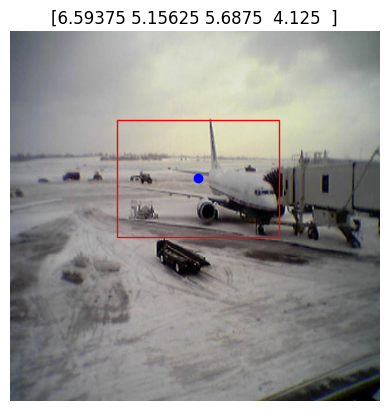

In [16]:
indices = np.argwhere(~np.all(y_batch[0, ..., :4] == 0, axis=-1))
sample_image, sample_box = x_batch[0], y_batch[0][tuple(indices[0])][:4]

plt.imshow(sample_image)
plt.plot(sample_box[0] * 416 / 13, sample_box[1] * 416 / 13, 'bo')
rect = patches.Rectangle((sample_box[0] * 416 / 13 - sample_box[2] * 416 / 13 / 2, 
                          sample_box[1] * 416 / 13 - sample_box[3] * 416 / 13 / 2),
                          sample_box[2] * 416 / 13, sample_box[3] * 416 / 13, 
                          linewidth=1, edgecolor='r', facecolor='none')
ax = plt.gca()
ax.add_patch(rect)
plt.axis('off')
plt.title(f"{sample_box}", fontsize=12)
plt.show()

# Image plotter with grid cells

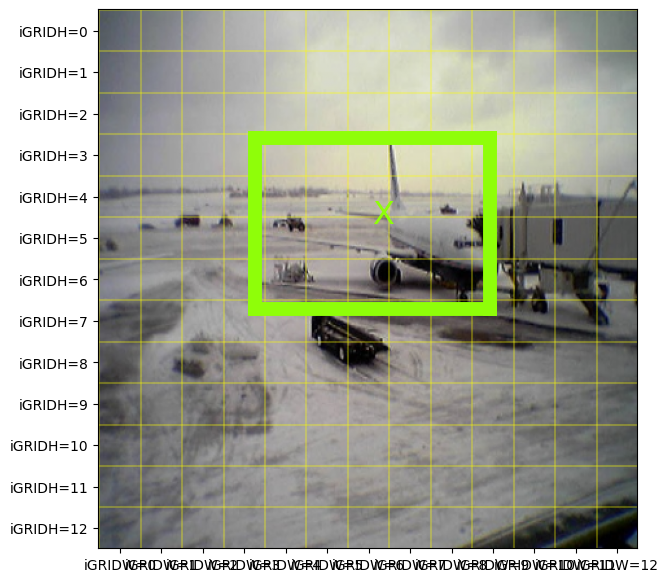

In [17]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(7,7))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_       = generator_config["GRID_"  + wh] ## 13
        IMAGE_      = generator_config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks

        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3)
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config["IMAGE_W"]/generator_config["GRID_W"]
                    multy = generator_config["IMAGE_H"]/generator_config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

plot_image_with_grid_cell_partition(frame_index)
plot_grid(frame_index)
plt.show()

# Some more image samples

------------------------------
frame=5, grid_h=04, grid_w=05, anchor_index=00, class=car
frame=5, grid_h=06, grid_w=08, anchor_index=01, class=person
frame=5, grid_h=08, grid_w=08, anchor_index=01, class=motorbike


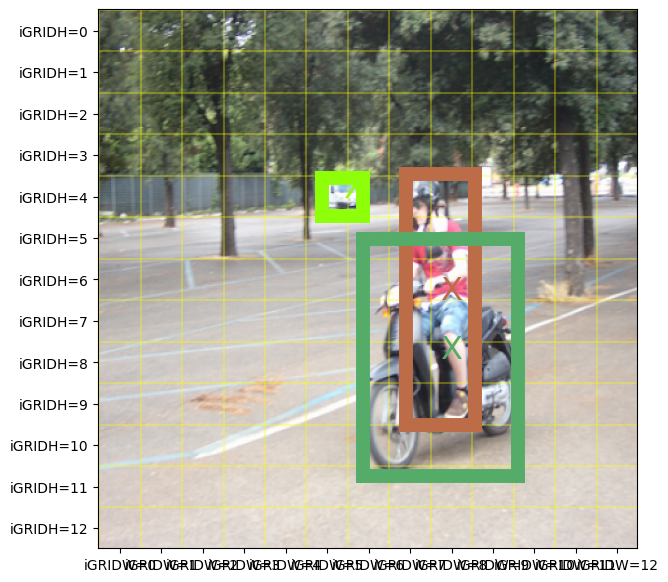

------------------------------
frame=6, grid_h=06, grid_w=01, anchor_index=00, class=car
frame=6, grid_h=06, grid_w=02, anchor_index=00, class=car
frame=6, grid_h=06, grid_w=07, anchor_index=03, class=bus
frame=6, grid_h=08, grid_w=01, anchor_index=01, class=car
frame=6, grid_h=10, grid_w=00, anchor_index=00, class=car


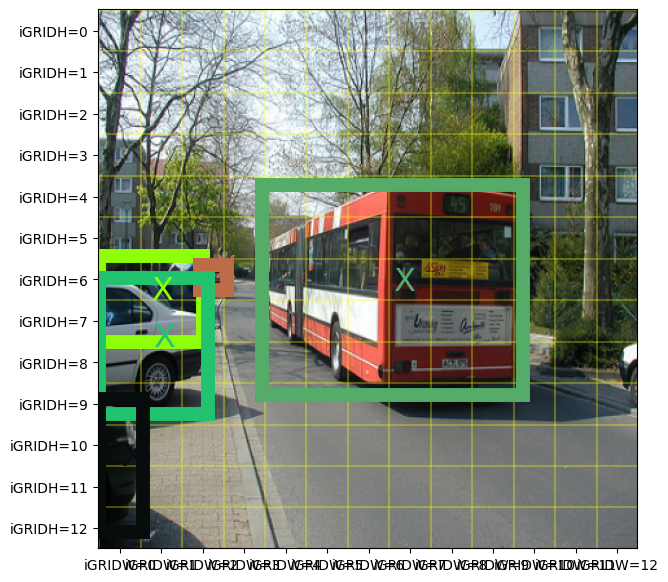

------------------------------
frame=7, grid_h=08, grid_w=05, anchor_index=03, class=person
frame=7, grid_h=08, grid_w=10, anchor_index=03, class=person
frame=7, grid_h=09, grid_w=06, anchor_index=02, class=boat


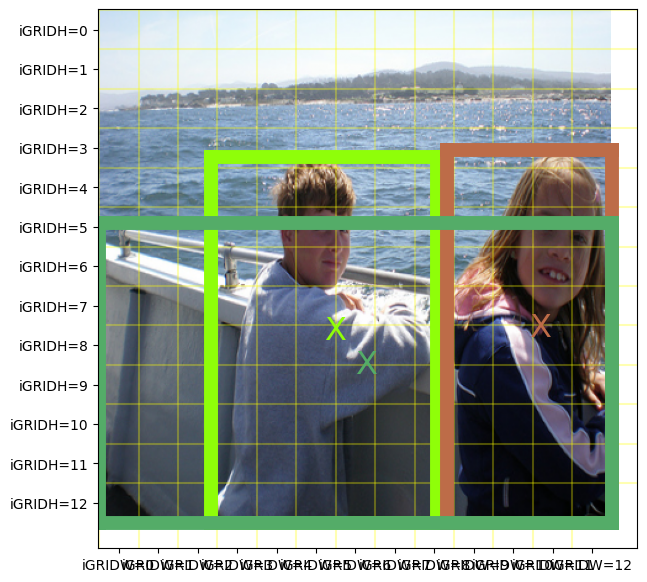

------------------------------
frame=8, grid_h=08, grid_w=06, anchor_index=01, class=cow


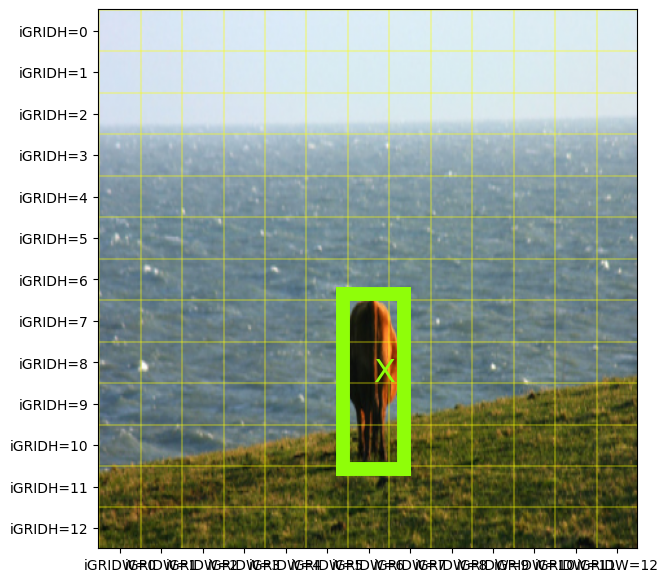

------------------------------
frame=9, grid_h=08, grid_w=05, anchor_index=01, class=person


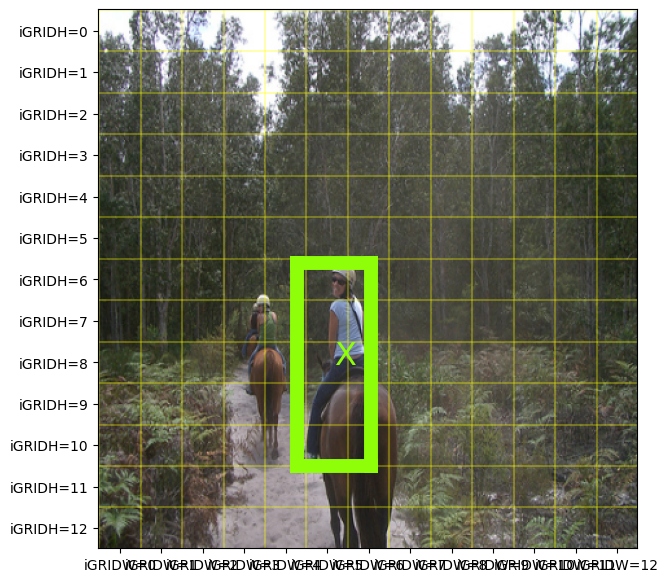

In [18]:
for frame in range(5, 10):
    print("-"*30)
    check_object_in_grid_anchor_pair(frame)
    plot_image_with_grid_cell_partition(frame)
    plot_grid(frame)
    plt.show()

# YOLO model architecture

![YOLO V2](https://www.maskaravivek.com/img/YOLOV2.png)

# Defning `Yolo v2` Model Architecture

In [19]:
# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

input_image_shape = Input(shape=(IMAGE_H, IMAGE_W, 3))
b_batch_const  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image_shape)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(BOX * (4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, b_batch_const])

model = Model([input_image_shape, b_batch_const], output)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 416, 416,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 416, 416,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_1              │ (None, 416, 416,  │        128 │ conv_1[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 416, 416,  │          0 │ norm_1[0][0]      │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 208, 208,  │          0 │ leaky_re_lu[0][0] │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 208, 208,  │     18,432 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_2              │ (None, 208, 208,  │        256 │ conv_2[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 208, 208,  │          0 │ norm_2[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 104, 104,  │          0 │ leaky_re_lu_1[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 104, 104,  │     73,728 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_3              │ (None, 104, 104,  │        512 │ conv_3[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 104, 104,  │          0 │ norm_3[0][0]      │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 104, 104,  │      8,192 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_4              │ (None, 104, 104,  │        256 │ conv_4[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 104, 104,  │          0 │ norm_4[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv2D)     │ (None, 104, 104,  │     73,728 │ leaky_re_lu_3[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_5              │ (None, 104, 104,  │        512 │ conv_5[0][0]    

 Total params: 50,650,436 (193.22 MB)

 Trainable params: 50,629,764 (193.14 MB)

 Non-trainable params: 20,672 (80.75 KB)

# Downloading the pre-trained weights for YOLO v2

In [20]:
!wget https://pjreddie.com/media/files/yolov2.weights # linux
# !curl -O https://pjreddie.com/media/files/yolov2.weights # windows

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-12-04 08:44:01--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: 'yolov2.weights'

yolov2.weights      100%[===================>] 194.49M  15.7MB/s    in 27s     

2024-12-04 08:44:31 (7.14 MB/s) - 'yolov2.weights' saved [203934260/203934260]



# `WeightReader` to extract weights from file

In [21]:
path_to_weight = "./yolov2.weights"

class WeightReader:
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def reset(self):
        self.offset = 4

weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


# Loading pre-trained weights into model 

In [22]:
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
    conv_layer = model.get_layer('conv_' + str(i))

    if i < nb_conv:
        norm_layer = model.get_layer('norm_' + str(i))

        input_shape = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(input_shape)
        gamma = weight_reader.read_bytes(input_shape)
        mean  = weight_reader.read_bytes(input_shape)
        var   = weight_reader.read_bytes(input_shape)

        weights = norm_layer.set_weights([gamma, beta, mean, var])

    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

In [23]:
layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

# Custom learning rate scheduler

In [24]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr

# `Model Loss`
## Loss constants

In [25]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

## Helper functions

In [26]:
def get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX):
    '''
    Helper function to assure that the bounding box x and y are in the grid cell scale
    == output ==
    for any i=0,1..,batch size - 1
    output[i,5,3,:,:] = array([[3., 5.],
                               [3., 5.],
                               [3., 5.]], dtype=float32)
    '''
    ## cell_x.shape = (1, 13, 13, 1, 1)
    ## cell_x[:,i,j,:] = [[[j]]]
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    ## cell_y.shape = (1, 13, 13, 1, 1)
    ## cell_y[:,i,j,:] = [[[i]]]
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    ## cell_gird.shape = (16, 13, 13, 5, 2)
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = j when k = 0
    ## for any n, k, i, j
    ##    cell_grid[n, i, j, anchor, k] = i when k = 1
    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return(cell_grid)

# get_cell_grid(13, 13, 16, 4) -> (16, 13, 13, 4, 2)
# get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX)[0][2][3][3] # 0th batch item, 2nd row, 3rd column, 3rd anchor: [3., 2.]
get_cell_grid(GRID_W,GRID_H,BATCH_SIZE,BOX).shape

TensorShape([16, 13, 13, 4, 2])

In [27]:
def scale_prediction(y_pred, cell_grid, ANCHORS):
    """
        Adjust prediction

        == input ==

        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)

        cell_grid : tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 2)

        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==

        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), contianing [center_y, center_x] rangining [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[irow,igrid_h,igrid_w,ianchor,1] =  center_1

          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate
                                                   takes values between 0 and grid_H - 1 for y coordinate

        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]

        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1

        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing
    """
    BOX = int(len(ANCHORS)/2)
    ## cell_grid is of the shape of

    ### adjust x and y
    # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
    # Since there are BOX x BOX grids, we rescale each bx and by to range between 0 to BOX + 1
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by

    ### adjust w and h
    # exp to make width and height positive
    # rescale each grid to make some anchor "good" at representing certain shape of bounding box
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,BOX,2]) # bw, bh

    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:] # prC1, prC2, ..., prC20

    # y_pred[..., :2] predicts offset from grid cell's top left corner
    # y_pred[..., 2:4] predicts proportion of width and height to use of particular anchor box
    # y_pred[..., 4] predicts confidence
    # y_pred[..., 5:] predicts each class probability

    return pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class

In [28]:
def print_min_max(vec,title):
  try:
    print("{} MIN={:5.2f}, MAX={:5.2f}".format(
        title,np.min(vec),np.max(vec)))
  except ValueError:  #raised if `y` is empty.
      pass

In [29]:
GRID_W = 13
GRID_H = 13
BOX    = int(len(ANCHORS)/2)
CLASS = len(LABELS)
input_shape = BATCH_SIZE, GRID_W, GRID_H, BOX, (4 + 1 + CLASS)

y_pred = np.random.normal(size = input_shape, scale = 10 / (GRID_H * GRID_W))
print("y_pred shape = {}".format(y_pred.shape))

y_pred_tf = tf.constant(y_pred, dtype="float32")
cell_grid = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)
(pred_box_xy,   pred_box_wh, pred_box_conf, pred_box_class) = scale_prediction(y_pred_tf, cell_grid, ANCHORS)

print("\npred_box_xy {}".format(pred_box_xy.shape))

for grid_w in range(pred_box_xy.shape[2]):
        print_min_max(pred_box_xy[:,:,grid_w,:,0], "  Bounding box x at GRID_W={:02.0f}".format(grid_w))
print()
for grid_h in range(pred_box_xy.shape[1]):
    print_min_max(pred_box_xy[:,grid_h,:,:,1], "  Bounding box y at GRID_H={:02.0f}".format(grid_h))

print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0],"  Bounding box width")
print_min_max(pred_box_wh[:,:,:,:,1],"  Bounding box height")

print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf,"  Confidence ")

print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class,"  Class probability")

y_pred shape = (16, 13, 13, 4, 25)

pred_box_xy (16, 13, 13, 4, 2)
  Bounding box x at GRID_W=00 MIN= 0.45, MAX= 0.55
  Bounding box x at GRID_W=01 MIN= 1.45, MAX= 1.56
  Bounding box x at GRID_W=02 MIN= 2.46, MAX= 2.55
  Bounding box x at GRID_W=03 MIN= 3.45, MAX= 3.54
  Bounding box x at GRID_W=04 MIN= 4.45, MAX= 4.55
  Bounding box x at GRID_W=05 MIN= 5.46, MAX= 5.55
  Bounding box x at GRID_W=06 MIN= 6.45, MAX= 6.56
  Bounding box x at GRID_W=07 MIN= 7.46, MAX= 7.55
  Bounding box x at GRID_W=08 MIN= 8.45, MAX= 8.54
  Bounding box x at GRID_W=09 MIN= 9.46, MAX= 9.55
  Bounding box x at GRID_W=10 MIN=10.45, MAX=10.55
  Bounding box x at GRID_W=11 MIN=11.44, MAX=11.54
  Bounding box x at GRID_W=12 MIN=12.45, MAX=12.55

  Bounding box y at GRID_H=00 MIN= 0.45, MAX= 0.56
  Bounding box y at GRID_H=01 MIN= 1.45, MAX= 1.55
  Bounding box y at GRID_H=02 MIN= 2.45, MAX= 2.55
  Bounding box y at GRID_H=03 MIN= 3.46, MAX= 3.54
  Bounding box y at GRID_H=04 MIN= 4.45, MAX= 4.55
  Bounding box

We extract the ground truth.

In [30]:
def extract_ground_truth(y_true):
    true_box_xy    = y_true[..., 0:2]               # x, y center in grid cell scale
    true_box_wh    = y_true[..., 2:4]               # width and height
    true_box_conf  = y_true[..., 4]                 # confidence (1 or 0)
    true_box_class = tf.argmax(y_true[..., 5:], -1) # index of class [1-20]
    return(true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [31]:
# y_batch is the output of the simpleBatchGenerator.fit()
print("y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch, dtype="float32")

# (16, 13, 13, 4, 2)       (16, 13, 13, 4)
(true_box_xy, true_box_wh, true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)
#             (16, 13, 13, 4, 2)          (16, 13, 13, 4)

print("\ntrue_box_xy {}".format(true_box_xy.shape))
for grid_w in range(true_box_xy.shape[2]):
    vec  = true_box_xy[:,:,grid_w,:,0]
    pick = true_box_conf[:,:,grid_w,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  Bounding box x at GRID_W={:02.0f}".format(grid_w))
print()
for grid_h in range(true_box_xy.shape[1]):
    vec  = true_box_xy[:,grid_h,:,:,1]
    pick = true_box_conf[:,grid_h,:,:] == 1 ## only pick C_ij = 1
    print_min_max(vec[pick],"  Bounding box y at GRID_H={:02.0f}".format(grid_h))

print("\ntrue_box_wh {}".format(true_box_wh.shape))
print_min_max(true_box_wh[:,:,:,:,0],"  Bounding box width ")
print_min_max(true_box_wh[:,:,:,:,1],"  Bounding box height")

print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("  Confidence, unique value = {}".format(np.unique(true_box_conf)))

print("\ntrue_box_class {}".format(true_box_class.shape))
print("  Class index, unique value = {}".format(np.unique(true_box_class)) )

y_batch = (16, 13, 13, 4, 25)

true_box_xy (16, 13, 13, 4, 2)
  Bounding box x at GRID_W=00 MIN= 0.53, MAX= 0.53
  Bounding box x at GRID_W=01 MIN= 1.25, MAX= 1.31
  Bounding box x at GRID_W=02 MIN= 2.77, MAX= 2.77
  Bounding box x at GRID_W=03 MIN= 3.06, MAX= 3.84
  Bounding box x at GRID_W=05 MIN= 5.17, MAX= 5.98
  Bounding box x at GRID_W=06 MIN= 6.36, MAX= 6.73
  Bounding box x at GRID_W=07 MIN= 7.08, MAX= 7.08
  Bounding box x at GRID_W=08 MIN= 8.14, MAX= 8.23
  Bounding box x at GRID_W=09 MIN= 9.31, MAX= 9.98
  Bounding box x at GRID_W=10 MIN=10.91, MAX=10.98

  Bounding box y at GRID_H=03 MIN= 3.16, MAX= 3.75
  Bounding box y at GRID_H=04 MIN= 4.12, MAX= 4.83
  Bounding box y at GRID_H=05 MIN= 5.16, MAX= 5.55
  Bounding box y at GRID_H=06 MIN= 6.30, MAX= 6.98
  Bounding box y at GRID_H=07 MIN= 7.02, MAX= 7.50
  Bounding box y at GRID_H=08 MIN= 8.11, MAX= 8.95
  Bounding box y at GRID_H=09 MIN= 9.20, MAX= 9.20
  Bounding box y at GRID_H=10 MIN=10.62, MAX=10.98
  Bounding box y at

In [32]:
#                 [, 4]                        [, :2]       [, :2]       [, 2:4]      [, 2:4]
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    #             (16, 13, 13, 4) (Scalar)     (..., 4, 2)  (..., 4, 2)  (..., 4, 2)  (..., 4, 2)


    # (16, 13, 13, 4, 1)    (16, 13, 13, 4)           (Scalar)
    coord  = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE 
    # coord -> cell which has object
    
    # scalar
    num_exist_box = tf.reduce_sum(tf.cast(coord > 0.0, tf.float32))
    # num_exist_box -> number of object in imageS

    # scalar                         (..., 4, 2)    (..., 4, 2)    (..., 4, 1)    (scalar)
    loss_xy = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord) / (num_exist_box + 1e-6) / 2.

    # scalar                         (..., 4, 2)    (..., 4, 2)    (..., 4, 1)    (scalar)
    loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord) / (num_exist_box + 1e-6) / 2.

    return (loss_xy + loss_wh, coord)

In [33]:
LAMBDA_COORD = 1
loss_xywh, coord  = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy,true_box_wh, pred_box_wh)

print("loss_xywh = {:4.3f}".format(loss_xywh))

loss_xywh = 4.686


In [34]:
#                                                               [..., 4, 5:]
def calc_loss_class(true_box_conf, CLASS_SCALE, true_box_class, pred_box_class):
#                   (..., 4)       (scalar)     (..., 4)        (..., 4, 20)
    '''
    == input ==
    true_box_conf  : tensor of shape (N batch, N grid h, N grid w, N anchor)
    true_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor), containing class index
    pred_box_class : tensor of shape (N batch, N grid h, N grid w, N anchor, N class)
    CLASS_SCALE    : 1.0

    == output ==
    class_mask
    if object exists in this (grid_cell, anchor) pair and the class object receive nonzero weight
        class_mask[iframe,igridy,igridx,ianchor] = 1
    else:
        0
    '''
    # (..., 4)     (..., 4)        (scalar)
    class_mask   = true_box_conf * CLASS_SCALE ## L_{i,j}^obj * lambda_class

    # (scalar)
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))

    loss_class   = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, logits = pred_box_class)
    loss_class   = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)

    return(loss_class)


In [35]:
LAMBDA_CLASS   = 1
loss_class  = calc_loss_class(true_box_conf,LAMBDA_CLASS,
                                 true_box_class,pred_box_class)
print("*"*30 + "\nouput\n" + "*"*30)
print("loss_class = {:4.3f}".format(loss_class))

******************************
ouput
******************************
loss_class = 3.004


In [36]:
#                      (..., 2) (..., 2) (..., 2) (..., 2)
def get_intersect_area(true_xy, true_wh, pred_xy, pred_wh):
    '''
    == INPUT ==
    true_xy, true_wh, pred_xy and pred_point must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1)
    t2 : true_maxs = (tx2,ty2)
                 p1______________________
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)

    '''
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half

    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half

    intersect_mins  = tf.maximum(pred_mins,  # (N batch, N grid_h, N grid_w, N anchor,               1, 2)
                                 true_mins)  # (N batch,        1,        1,        1, TRUE_BOX_BUFFER, 2)
    
    intersect_maxes = tf.minimum(pred_maxes, # (N batch, N grid_h, N grid_w, N anchor,               1, 2)
                                 true_maxes) # (N batch,        1,        1,        1, TRUE_BOX_BUFFER, 2)
    
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    return(iou_scores)

def calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh):
    '''
    == input ==

    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)

    == output ==

    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)

    true_box_conf value depends on the predicted values
    true_box_conf = IOU_{true,pred} if objecte exist in this anchor else 0
    '''
    # (16, 13, 13, 4) scalar for each grid's anchor
    iou_scores        =  get_intersect_area(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    #                kind of masking (16, 13, 13, 4) scalar 1 or 0 for each grid's anchor

    return(true_box_conf_IOU)

true_box_conf.shape = (16, 13, 13, 4)
true_box_xy.shape   = (16, 13, 13, 4, 2)
true_box_wh.shape   = (16, 13, 13, 4, 2)
pred_box_xy.shape   = (16, 13, 13, 4, 2)
pred_box_wh.shape   = (16, 13, 13, 4, 2)
true_box_conf_IOU.shape = (16, 13, 13, 4)


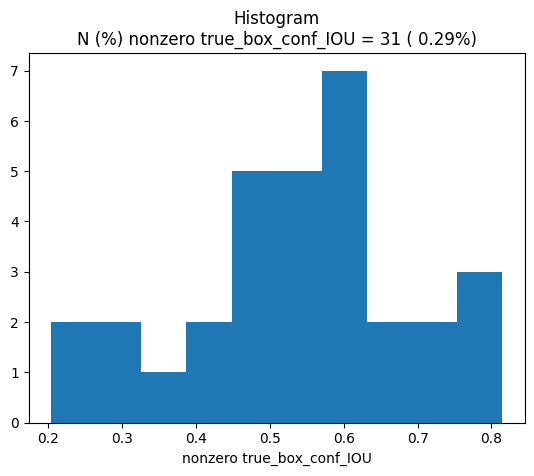

In [37]:
# (16, 13, 13, 4)                              (16, 13, 13, 4) (16, 13, 13, 4, 2)        (16, 13, 13, 4, 2)
best_iou_with_cell = calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
#                                                                           (16, 13, 13, 4, 2)        (16, 13, 13, 4, 2)

print("true_box_conf.shape = {}".format(true_box_conf.shape))
print("true_box_xy.shape   = {}".format(true_box_xy.shape))
print("true_box_wh.shape   = {}".format(true_box_wh.shape))
print("pred_box_xy.shape   = {}".format(pred_box_xy.shape))
print("pred_box_wh.shape   = {}".format(pred_box_wh.shape))
print("true_box_conf_IOU.shape = {}".format(best_iou_with_cell.shape))

vec  = best_iou_with_cell
pick = vec != 0
vec  = vec[pick]

plt.hist(vec)
plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick), 100*np.mean(pick)))
plt.xlabel("nonzero true_box_conf_IOU")
plt.show()

In [38]:
def calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, b_batch_const):
    '''
    == input ==
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor,       2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor,       2)
    b_batch_const : tensor of shape (N batch,        1,        1,        1, N_BOXES, 4)

    == output ==

    best_iou_with_image

    for each iframe,
        best_iou_with_image[iframe,igridy,igridx,ianchor] contains

        the IOU of the object that is most likely included (or best fitted)
        within the bounded box recorded in (grid_cell, anchor) pair

        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_iou_with_image, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = b_batch_const[..., 0:2]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)
    true_wh = b_batch_const[..., 2:4]           # (N batch, 1, 1, 1, TRUE_BOX_BUFFER, 2)

    pred_xy = tf.expand_dims(pred_box_xy, 4)    # (N batch, N grid_h, N grid_w, N anchor, 1, 2)
    pred_wh = tf.expand_dims(pred_box_wh, 4)    # (N batch, N grid_h, N grid_w, N anchor, 1, 2)

    # (N batch, N grid_h, N grid_w, N anchor, TRUE_BOX_BUFFER)
    iou_scores  =  get_intersect_area(true_xy,  # (N batch,        1,        1,        1, TRUE_BOX_BUFFER, 2)
                                      true_wh,  # (N batch,        1,        1,        1, TRUE_BOX_BUFFER, 2)
                                      pred_xy,  # (N batch, N grid_h, N grid_w, N anchor,               1, 2)
                                      pred_wh)  # (N batch, N grid_h, N grid_w, N anchor,               1, 2)

    # (N batch, N grid_h, N grid_w, N anchor) <- (N batch, N grid_h, N grid_w, N anchor, TRUE_BOX_BUFFER)
    best_iou_with_image = tf.reduce_max(iou_scores, axis=4)

    return(best_iou_with_image)

pred_box_xy.shape        = (16, 13, 13, 4, 2)
pred_box_wh.shape        = (16, 13, 13, 4, 2)
b_batch_const.shape      = (16, 1, 1, 1, 50, 4)
best_iou_with_image.shape = (16, 13, 13, 4)


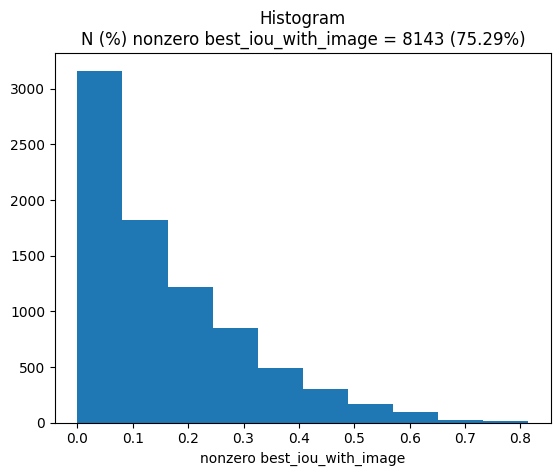

In [39]:
# (16, 1, 1, 1, 50, 4)     (16, 1, 1, 1, 50, 4)
b_batch_const = tf.constant(b_batch, dtype="float32")

# (16, 13, 13, 4, 50)              (16, 13, 13, 4) (16, 13, 13, 4) (16, 1, 1, 1, 50, 4)
best_iou_with_image = calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, b_batch_const)

# best_iou_with_image represents each image-grid-anchor box's "Best IOU"
# compared with each of the 50 ground truth rectangles of image

print("pred_box_xy.shape        = {}".format(pred_box_xy.shape))
print("pred_box_wh.shape        = {}".format(pred_box_wh.shape))
print("b_batch_const.shape      = {}".format(b_batch_const.shape))
print("best_iou_with_image.shape = {}".format(best_iou_with_image.shape))

vec  = best_iou_with_image
pick = vec != 0
vec  = vec[pick]
plt.hist(vec)
plt.title("Histogram\nN (%) nonzero best_iou_with_image = {} ({:5.2f}%)".format(np.sum(pick), 100*np.mean(pick)))
plt.xlabel("nonzero best_iou_with_image")
plt.show()

In [40]:
#                (16, 13, 13, 4)       (16, 13, 13, 4)(16, 13, 13, 4)
def get_conf_mask(best_iou_with_image, true_box_conf, best_iou_with_cell, LAMBDA_NO_OBJECT, LAMBDA_OBJECT):
    '''
    == input ==

    best_iou_with_image : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    best_iou_with_cell  : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0

    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)

    conf_mask[iframe, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e.
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6

    conf_mask[iframe, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[iframe,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6

    conf_mask[iframe, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair
    '''

    # conf_mask 1 if there is no object(0) of that anchor shape and best_iou compared to all rectangle in image is less than 0.6
    conf_mask = tf.cast(best_iou_with_image < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    #(L_N_O)1 =                         0.5 < 0.6                     0
    #       0 =                         0.5 < 0.6                     1
    #       0 =                         0.7 < 0.6                     0
    #       0 =                         0.5 < 0.6                     1

    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + best_iou_with_cell * LAMBDA_OBJECT

    return(conf_mask)

In [41]:
conf_mask = get_conf_mask(best_iou_with_image,  # (Nbatch, N grid h, N grid w, N anchor) # best anchor's IOU compared with 50 ground truths
                          true_box_conf,        # (Nbatch, N grid h, N grid w, N anchor) # 1 or 0
                          best_iou_with_cell,   # (Nbatch, N grid h, N grid w, N anchor) # best anchor's IOU compared with the predicted box
                          LAMBDA_NO_OBJECT,     # (Scalar)
                          LAMBDA_OBJECT)        # (Scalar)

print("best_iou_with_image = {}".format(best_iou_with_image.shape))
print("true_box_conf       = {}".format(true_box_conf.shape))
print("best_iou_with_cell  = {}".format(best_iou_with_cell.shape))
print("LAMBDA_NO_OBJECT    = {}".format(LAMBDA_NO_OBJECT))
print("LAMBDA_OBJECT       = {}".format(LAMBDA_OBJECT))
print("conf_mask           = {}".format(conf_mask.shape))

best_iou_with_image = (16, 13, 13, 4)
true_box_conf       = (16, 13, 13, 4)
best_iou_with_cell  = (16, 13, 13, 4)
LAMBDA_NO_OBJECT    = 1.0
LAMBDA_OBJECT       = 5.0
conf_mask           = (16, 13, 13, 4)


In [42]:
def calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf):
    '''
    == input ==

    conf_mask         : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    pred_box_conf     : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    '''
    # the number of (grid cell, anchor) pair that has an assigned object or
    # that has no assigned object but some objects may be in bounding box.
    # N conf                            (16, 13, 13, 4)
    nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask > 0.0, tf.float32))
    # (Scalar)

    # (Scalar)                            (16, 13, 13, 4)      (16, 13, 13, 4)
    loss_conf    = tf.reduce_sum(tf.square(true_box_conf_IOU - pred_box_conf) * conf_mask) / (nb_conf_box + 1e-6) / 2.

    return(loss_conf)

In [43]:
print("conf_mask         = {}".format(conf_mask))
print("true_box_conf_IOU = {}".format(best_iou_with_cell))
print("pred_box_conf     = {}".format(pred_box_conf))

loss_conf = calc_loss_conf(conf_mask,best_iou_with_cell, pred_box_conf)

print("loss_conf = {:5.4f}".format(loss_conf))

conf_mask         = [[[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  ...

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]]


 [[[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]]

  [[1. 1. 1. 1.]
   [1. 1. 1. 1.]
   [1. 1. 1. 1.]
   ...
   [1. 1. 1. 1.]
   [1. 1

# Custom Loss function

In [44]:
#              (16, 13, 13, 4, 25),  Same
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h

        center_x : The x coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        center_y : The y coordinate center of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)
        w        : The width of the bounding box.
                   Rescaled to range between 0 and N gird  w (e.g., ranging between [0,13)
        h        : The height of the bounding box.
                   Rescaled to range between 0 and N gird  h (e.g., ranging between [0,13)

    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence

        ground truth confidence is 1 if object exists in this (anchor box, gird cell) pair

    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0

    '''
    total_recall = tf.Variable(0.)

    # Step 1: Adjust prediction output
    # (16, 13, 13, 4 ,2)       (13      13      16          4)
    cell_grid   = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)

    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = scale_prediction(y_pred, cell_grid, ANCHORS)
    # (..., 2)   (..., 2)     (..., 1)       (..., 20)
    
    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)
    # (..., 2)   (..., 2)     (..., 1)       (..., 20)
    
    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh)
    # (scalar) 

    # Step 4: Calculate loss for the class probabilities
    loss_class  = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)
    # (scalar) 
    
    # Step 5: For each (grid cell, anchor) pair,
    #         calculate the IoU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf,
                                                    true_box_xy, true_box_wh,
                                                    pred_box_xy, pred_box_wh)
    # (16, 13, 13, 4)

    # Step 6: For each predicted bounded box from (grid cell, anchor box),
    #         calculate the best IOU, regardless of the ground truth anchor box that each object gets assigned.
    best_ious = calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, b_batch_const)
    # (16, 13, 13, 4)
    
    # Step 7: For each grid cell, calculate the L_{i,j}^{noobj}
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU, LAMBDA_NO_OBJECT, LAMBDA_OBJECT)
    # (16, 13, 13, 4)
    
    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf)
    # (scalar) 

    #      (scalar)    (scalar)    (scalar) 
    loss = loss_xywh + loss_conf + loss_class

    return loss

# Sample usage of `custom_loss`

In [45]:
print(y_batch.dtype, y_pred.dtype)
b_batch_const = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32'))
print('loss', loss)

float64 float64
loss tf.Tensor(7.814527, shape=(), dtype=float32)


# `Callback` for saving the weights and `Compiling` the model before training

In [46]:
dir_log = "logs/"
try:
    os.makedirs(dir_log)
except:
    pass


generator_config['BATCH_SIZE'] = BATCH_SIZE

early_stop = EarlyStopping(monitor='loss',
                           min_delta=0.001,
                           patience=3,
                           mode='min',
                           verbose=1)

checkpoint = ModelCheckpoint('/kaggle/working/weights_yolo_on_voc2012.keras',
                             monitor='loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min',
                             save_freq='epoch')

optimizer = Adam(learning_rate=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss=custom_loss, optimizer=optimizer)

/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


# `Training` the model

In [47]:
tf.config.experimental_run_functions_eagerly(True)

model.fit(train_batch_generator,
          steps_per_epoch = len(train_batch_generator),
          epochs          = 50,
          verbose         = 1,
          callbacks       = [early_stop, checkpoint])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1071/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - loss: 2.5706
Epoch 1: loss improved from inf to 1.71143, saving model to /kaggle/working/weights_yolo_on_voc2012.keras
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 965s 891ms/step - loss: 2.5698
Epoch 2/50

Epoch 2: loss improved from 1.71143 to 0.00000, saving model to /kaggle/working/weights_yolo_on_voc2012.keras


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1071/1071 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0000e+00
Epoch 3/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - loss: 0.7141
Epoch 3: loss did not improve from 0.00000
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 955s 890ms/step - loss: 0.7141
Epoch 4/50

Epoch 4: loss did not improve from 0.00000
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 4us/step - loss: 0.0000e+00
Epoch 5/50
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - loss: 0.4296
Epoch 5: loss did not improve from 0.00000
1071/1071 ━━━━━━━━━━━━━━━━━━━━ 953s 888ms/step - loss: 0.4296
Epoch 5: early stopping


# Evaluation

In [48]:
imageReader = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
out = imageReader.fit(train_image_folder + "/2007_005430.jpg")

In [49]:
print(out.shape)
X_test = np.expand_dims(out,0)
print(X_test.shape)
# handle the hack input
dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
(1, 13, 13, 4, 25)


# `OutputRescaler` to scaling up `y_pred`

In [50]:
class OutputRescaler(object):
    def __init__(self,ANCHORS):
        self.ANCHORS = ANCHORS

    def _sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
        
    def _softmax(self, x, axis=-1, t=-100.):
        x = x - np.max(x)

        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims=True)

    #                            (13, 13, 4, 25)
    def get_shifting_matrix(self,netout):

        # 13,   13,      4
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        # (13, 13, 4)
        no = netout[...,0]

        # (4,)
        ANCHORSw = self.ANCHORS[::2]
        ANCHORSh = self.ANCHORS[1::2]
        # (4,)

        # (13, 13, 4)
        mat_GRID_W = np.zeros_like(no)
        #   (0)        (0 to 12)
        for igrid_w in range(GRID_W): # (scalar)
            mat_GRID_W[:,igrid_w,:] = igrid_w
        #   (13, (0), 4)             = (0)

        # (13, 13, 4)
        mat_GRID_H = np.zeros_like(no)
        #   (0)        (0 to 12)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h
        #   ((0), 13, 4)             = (0)
        
        # (13, 13, 4)
        mat_ANCHOR_W = np.zeros_like(no)
        #   (0)        (0 to 4)
        for ianchor in range(BOX):
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]
        #   (13, 13, (0))              = (0)
        
        # (13, 13, 4)
        mat_ANCHOR_H = np.zeros_like(no)
        #   (0)        (0 to 4)
        for ianchor in range(BOX):
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]
        #   (13, 13, (0))              = (0)
        
        return(mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H)

    def fit(self, netout):
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)

        a single image output of model.predict()
        '''
        #                     (13, 13, 4, 25)
        GRID_H, GRID_W, BOX = netout.shape[:3]

        (
            mat_GRID_W, # (13, 13, 4)
            mat_GRID_H, # (13, 13, 4)
            mat_ANCHOR_W, # (13, 13, 4)
            mat_ANCHOR_H # (13, 13, 4)
        ) = self.get_shifting_matrix(netout) # (13, 13, 4, 25)


        # bounding box parameters
        # (13, 13, 4)      (13, 13, 4)   (13, 13, 4, 25)    (13, 13, 4) (scalar)
        netout[..., 0]   = (self._sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1

        # (13, 13, 4)      (13, 13, 4)   (13, 13, 4, 25)    (13, 13, 4) (scalar)
        netout[..., 1]   = (self._sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1

        # (13, 13, 4)      (13, 13, 4)               (13, 13, 4) (scalar)
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1

        # (13, 13, 4)      (13, 13, 4)              (13, 13, 4) (scalar)
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        
        # rescale the confidence to range 0 and 1
        netout[..., 4]   = self._sigmoid(netout[..., 4])

        expand_conf      = np.expand_dims(netout[...,4], -1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        # (13, 13, 4, 20)  (13, 13, 4, 1)             (13, 13, 4, 20)
        netout[..., 5:]  = expand_conf * self._softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold

        return(netout)

# Sample usage of `OutputRescaler`

In [51]:
netout         = y_pred[0]
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
netout_scale   = outputRescaler.fit(netout)
netout.shape, netout_scale.shape

((13, 13, 4, 25), (13, 13, 4, 25))

# Selecting object with highest probability

In [52]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input ==
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)

             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    == Output ==

    boxes  : list containing bounding box with Pr(object is in class C) > 0 for at least in one class C


    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]

    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]

                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return(boxes)

# Checking number of object exist above `threshold`

In [53]:
obj_threshold = 0.015
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.03
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.015
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 65 bounding boxes with top class probability > 0.015

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 676 bounding boxes 
I found 28 bounding boxes with top class probability > 0.03


# Function to draw bounding boxes on the image

Plot with low object threshold
aeroplane  0.021 xmin=  10,ymin=   0,xmax= 403,ymax= 167
sofa       0.029 xmin=   0,ymin=   0,xmax= 314,ymax= 210
person     0.020 xmin= 128,ymin=   2,xmax= 222,ymax= 161
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.021 xmin=  73,ymin=   0,xmax= 278,ymax= 203
person     0.045 xmin= 160,ymin=  10,xmax= 255,ymax= 151
sofa       0.018 xmin=  25,ymin=   0,xmax= 389,ymax= 213
person     0.016 xmin= 216,ymin=  51,xmax= 262,ymax= 105


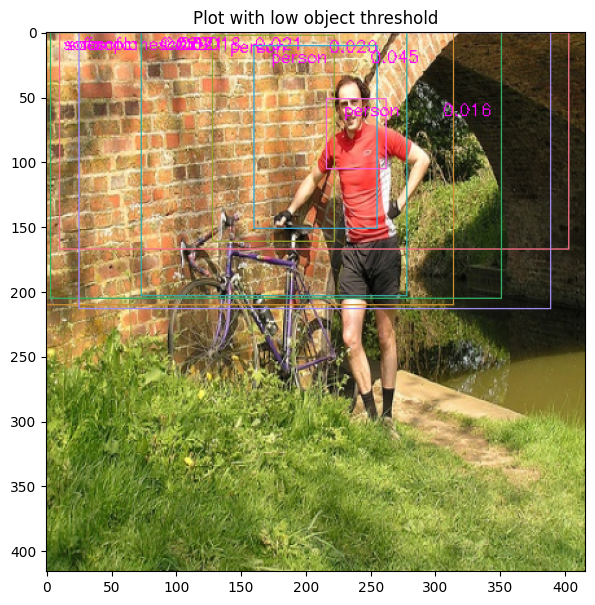

Plot with high object threshold
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
person     0.045 xmin= 160,ymin=  10,xmax= 255,ymax= 151
person     0.119 xmin= 190,ymin=  18,xmax= 293,ymax= 147
person     0.041 xmin= 165,ymin=  28,xmax= 253,ymax= 195
person     0.138 xmin= 189,ymin=  37,xmax= 292,ymax= 188
person     0.059 xmin= 162,ymin=   0,xmax= 313,ymax= 245
sofa       0.032 xmin=   2,ymin=  11,xmax= 161,ymax= 277
person     0.078 xmin= 174,ymin=  43,xmax= 255,ymax= 258


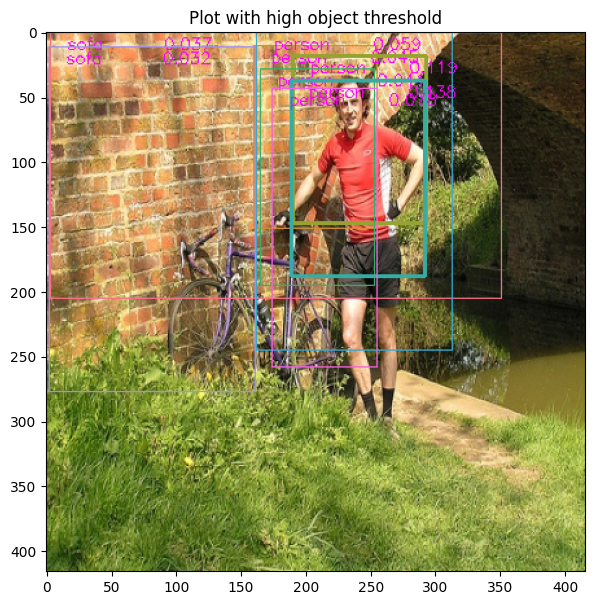

In [54]:
import cv2, copy
import seaborn as sns
def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0
        if c > _max:
            c = _max
        return c

    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline

    colors = sns.color_palette("husl", 8)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)


        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image,
                      pt1=(xmin,ymin),
                      pt2=(xmax,ymax),
                      color=color,
                      thickness=int(sr))
        cv2.putText(img       = image,
                    text      = text,
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)

    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,LABELS,verbose=True)
figsize = (7,7)
plt.figure(figsize=figsize)
plt.imshow(ima);
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,LABELS,verbose=True)
figsize = (7,7)
plt.figure(figsize=figsize)
plt.imshow(ima);
plt.title("Plot with high object threshold")
plt.show()

# `Nonmax suppresion` that chooses the bounding box with the highest `IOU`

In [55]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])

    CLASS    = len(boxes[0].classes)
    index_boxes = []
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]

            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]

                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.find_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)

    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]

    return newboxes

# Threshold checker

In [56]:
iou_threshold = 0.01
final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

12 final number of boxes


# Final prediction

sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
bicycle    0.080 xmin=  99,ymin= 137,xmax= 235,ymax= 286
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205
sofa       0.037 xmin=   3,ymin=   0,xmax= 351,ymax= 205


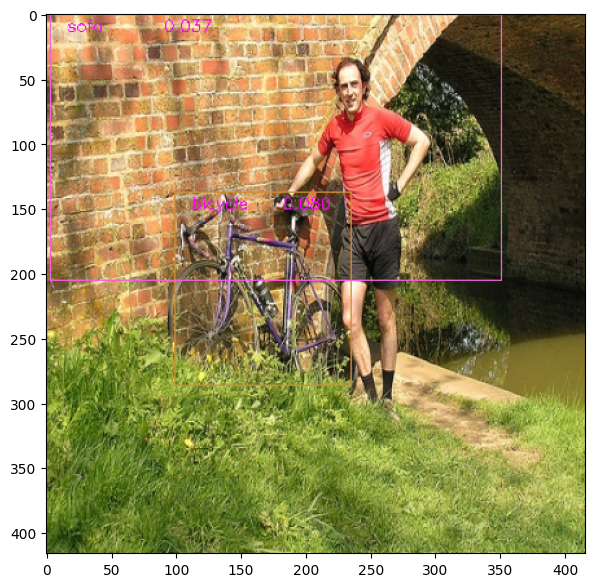

In [57]:
ima = draw_boxes(X_test[0],final_boxes,LABELS,verbose=True)
figsize = (7,7)
plt.figure(figsize=figsize)
plt.imshow(ima);
plt.show()

# Predicting some more images

In [58]:
np.random.seed(1)
Nsample   = 2
image_nms = list(np.random.choice(os.listdir(train_image_folder),Nsample))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
car        0.041 xmin=  40,ymin=   0,xmax= 372,ymax= 147
motorbike  0.617 xmin=  22,ymin=  15,xmax= 396,ymax= 396
person     0.067 xmin= 127,ymin=  22,xmax= 221,ymax= 201


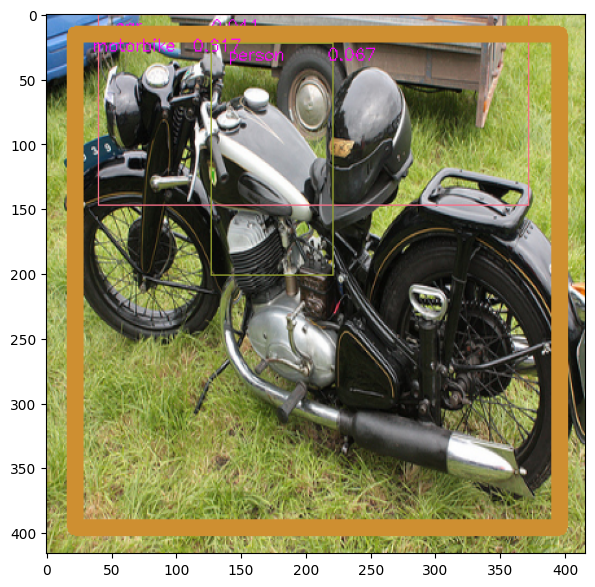

car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117
car        0.063 xmin=   1,ymin=  45,xmax= 113,ymax= 117


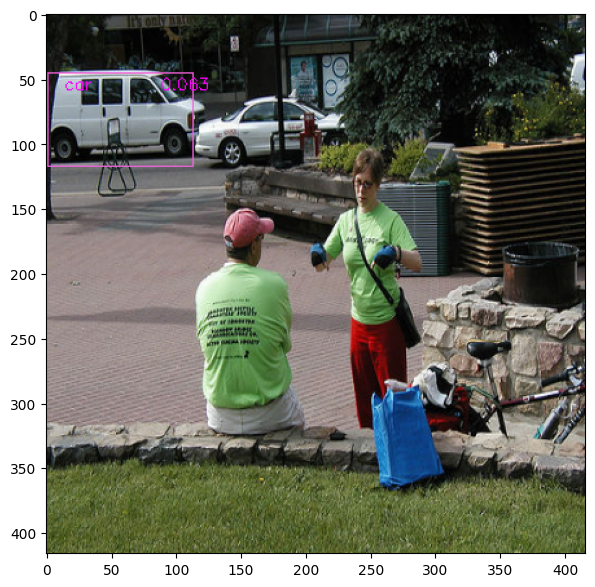

In [59]:
outputRescaler = OutputRescaler(ANCHORS=ANCHORS)
imageReader    = ImageReader(IMAGE_H,IMAGE_W=IMAGE_W, norm=lambda image : image / 255.)
X_test         = []
for img_nm in image_nms:
    _path    = os.path.join(train_image_folder,img_nm)
    out      = imageReader.fit(_path)
    X_test.append(out)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,TRUE_BOX_BUFFER,4))
y_pred         = model.predict([X_test,dummy_array])

for frame_index in range(len(y_pred)):
        netout         = y_pred[frame_index]
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,
                                                iou_threshold=iou_threshold,
                                                obj_threshold=obj_threshold)
            ima = draw_boxes(X_test[frame_index],final_boxes,LABELS,verbose=True)
            plt.figure(figsize=figsize)
            plt.imshow(ima);
            plt.show()